# CPSC 4300/6300: Applied Data Science

## Supervised Classification

**Clemson University**<br>
**Spring 2023**<br>
**Instructor(s):** Nina Hubig <br>
**Co-Author(s):** Brandon Walker

<span style="color: orange;">

### PARAMPREET SINGH, C19377466
</span>

---



In [35]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

## Part 1:  The AirBnB NYC 2019 Dataset + EDA
The dataset contains information about AirBnB hosts in NYC from 2019. There are 49k unique hosts and 16 features for each:

- **id:** listing ID
- **name:** name of the listing
- **host_id:** host ID
- **host_name:** name of the host
- **neighbourhood_group:** NYC borough
- **neighbourhood:** neighborhood
- **latitude:** latitude coordinates
- **longitude:** longitude coordinates
- **room_type:** listing space type (e.g., private room, entire home)
- **price:** price in dollars per night
- **minimum_nights:** number of min. nights required for booking
- **number_of_reviews:** number of reviews
- **last_review:** date of the last review
- **reviews_per_month:** number of reviews per month
- **calculated_host_listings_count:** number of listings the host has
- **availability_365:** number of days the listing is available for booking

Our goal is to predict the price of unseen housing units as being 'affordable' or 'unaffordable', by using their features. We will assume that this task is for a particular client who has a specific budget and would like to simplify the problem by classifying any unit that costs \< \\$150 per night as 'affordable' and any unit that costs \\$150 or great as 'unaffordable'.

For this task, we will exercise our normal data science pipeline -- from EDA to modelling and visualization. In particular, we will show the performance of two different classifiers:

- Linear Regression
- Logistic Regression


### Read-in and checking
We do the usual read-in and verification of the data:

In [2]:
df = pd.read_csv("nyc_airbnb.csv")
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Building the training/dev/testing data
As usual, we split the data before we begin our analysis. It would be unfair to cheat by looking at the testing data. Let's divide the data into 60% training, 20% development (aka validation), 20% testing. However, before we split the data, let's make the simple transformation and converting the prices into a categories of being _affordable_ or not.

In [3]:
df['affordable'] = np.where(df['price'] < 150, 1, 0)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,affordable
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,1
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,1
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1


**NOTE:** The `affordable` column now has a value of 1 whenever the price is < 150, and 0 otherwise.

Also, the feature named `neighbourhood_group` can be easily confused with `neighbourhood`, so let's go ahead and rename it to `borough`, as that is more distinct:

In [4]:
df.rename(columns={"neighbourhood_group": "borough"}, inplace=True)
df.head()

,id,name,host_id,host_name,borough,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,affordable
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,1
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,1
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1


Without looking at the full data yet, let's just ensure our prices are within valid ranges:

In [5]:
df['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Uh-oh. We see that `price` has a minimum value of \\$0. I highly doubt any unit in NYC is free. These data instances are garbage, so let's go ahead and remove any instance that has a price of \\$0.

In [6]:
print("original training size:", df.shape)
df = df.loc[df['price'] != 0]
print("new training size:", df.shape)

original training size: (48895, 17)
new training size: (48884, 17)


Now, let's split the data while ensuring that our test set has a fair distribution of affordable units, then further split our training set so as to create the development set:

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['affordable'])
df_train, df_dev = train_test_split(df_train, test_size=0.25, random_state=99)

# ensure our dataset splits are of the % sizes we want
total_size = len(df_train) + len(df_dev) + len(df_test)
print("train:", len(df_train), "=>", len(df_train) / total_size)
print("dev:", len(df_dev), " =>", len(df_dev) / total_size)
print("test:", len(df_test), "=>", len(df_test) / total_size)

train: 29330 => 0.5999918173635546
dev: 9777  => 0.20000409131822272
test: 9777 => 0.20000409131822272


Let's remove the target value (i.e., __affordable__) from our current dataframes and create it as separate prediction dataframes.

In [8]:
# training
x_train = df_train.drop(['price', 'affordable'], axis=1)
y_train = pd.DataFrame(data=df_train['affordable'], columns=["affordable"])

# dev
x_dev = df_dev.drop(['price', 'affordable'], axis=1)
y_dev = pd.DataFrame(data=df_dev['affordable'], columns=["affordable"])

# test
x_test = df_test.drop(['price', 'affordable'], axis=1)
y_test = pd.DataFrame(data=df_test['affordable'], columns=["affordable"])

From now onwards, we will do EDA and cleaning based on the training set, `x_train`.

In [9]:
for col in x_train.columns:
    print(col, ":", np.sum([x_train[col].isnull()]))

id : 0
name : 12
host_id : 0
host_name : 12
borough : 0
neighbourhood : 0
latitude : 0
longitude : 0
room_type : 0
minimum_nights : 0
number_of_reviews : 0
last_review : 6065
reviews_per_month : 6065
calculated_host_listings_count : 0
availability_365 : 0


It appears ~6k of the rows have missing values concerning the reviews. It seems impossible to impute the `last_review` feature with reasonable values, as this is very specific to each unit. At best, we could guess the date based on the `reviews_per_month`, but that feature is missing for the same rows. Further, it might be difficult to replace `reviews_per_month` with reasonable values -- sure, we could fill in values to be the median value, but that seems wrong to generalize so heavily, especially for over 20% of our data. Consequently, let's just ignore these two columns.

In [10]:
x_train = x_train.drop(['last_review', 'reviews_per_month'], axis=1)
x_dev = x_dev.drop(['last_review', 'reviews_per_month'], axis=1)
x_test = x_test.drop(['last_review', 'reviews_per_month'], axis=1)

Let's look at the summary statistics of the data:

In [11]:
x_train.describe()

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,2.933000e+04,2.933000e+04,29330.000000,29330.000000,29330.000000,29330.000000,29330.000000,29330.000000
mean,1.899091e+07,6.746725e+07,40.729049,-73.952129,6.891647,23.490829,7.111081,113.047017
std,1.102972e+07,7.863754e+07,0.054446,0.046320,19.236816,45.324235,32.904893,131.845296
min,2.539000e+03,2.438000e+03,40.499790,-74.242850,1.000000,0.000000,1.000000,0.000000
25%,9.380684e+06,7.794212e+06,40.690423,-73.983130,1.000000,1.000000,1.000000,0.000000
50%,1.960499e+07,3.049924e+07,40.723090,-73.955630,3.000000,5.000000,1.000000,44.000000
75%,2.921518e+07,1.074344e+08,40.763067,-73.936100,5.000000,24.000000,2.000000,228.000000
max,3.648561e+07,2.743213e+08,40.913060,-73.712990,1000.000000,629.000000,327.000000,365.000000


Next, we see that the `minimum_nights` feature has a maximum value of 1,250. That's almost 3.5 years, which is probably longer than the duration that most people rent an apartment. This seems anomalous and wrong. Let's discard it and other units that are outrageous. Well, what constitutes 'outrageous'? We see that the standard deviation for `minimum_nights` is 21.24. If we assume our distribution of values are normally distributed, then only using values that are within 2 standard deviations of the mean would yield us with ~95% of the original data. However, we have no reason to believe our data is actually normally distributed, especially since our mean is 7. To have a better idea of our actual values, let's plot it as a histogram.

Text(0, 0.5, 'count')

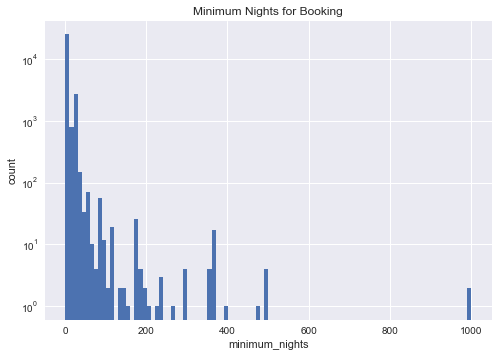

In [12]:
x_train['minimum_nights'].plot(kind='hist', bins=100, log=True)
plt.title('Minimum Nights for Booking')
plt.xlabel('minimum_nights')
plt.ylabel('count')

Yea, that instance was a strong outlier, and the host was being ridiculously greedy. That's a clever way to get out a multi-year lease. Notice that we are using log-scale. Clearly, a lot of our mass is from units less than 365 days. To get a better sense of that subset, let's re-plot only units with minumum_nights < 365 days.

Text(0, 0.5, 'count')

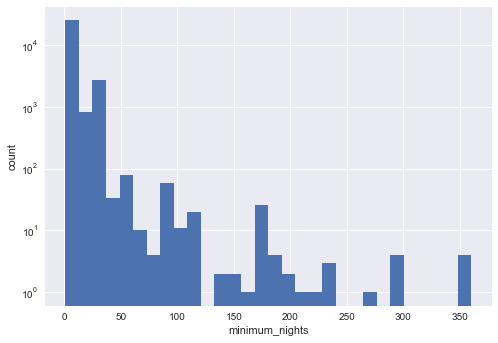

In [13]:
subset = x_train['minimum_nights']<365
fig, ax = plt.subplots(1,1)
ax.hist(x_train['minimum_nights'][subset], 30, log=True)
plt.xlabel('minimum_nights')
plt.ylabel('count')

Ok, that doesn't look too bad, as most units require < 30 nights. It's surprising that some hosts list an unreasonable requirement for the minimum number of nights. There is a risk that any host that lists such an unreasonable value might also have other incorrect information. Personally, I think anything beyond 30 days could be suspicious. If we were to exclude any unit that requires more than 30 days, how many instances would we be ignoring?

In [14]:
len(x_train.loc[x_train['minimum_nights']>30])

436

Alright, we'd be throwing away 436 out of our ~30k entries. That's roughly 1.5\% of our data. While we generally want to keep and use as much data as we can, I think this is an okay amount to discard, especially considering (1) we have a decently large amount of data remaining, and (2) the entries beyond a 30-day-min could be unrealiable.

In [15]:
good_subset = x_train['minimum_nights'] <= 30
x_train = x_train.loc[good_subset]
y_train = y_train.loc[good_subset]

Notice that we only trimmed our training data, not our development or testing data. I am making this choice because in real scenarios, we would not know the nature of the testing data values. We pre-processed our data to ignore all data that has a price of $0, and to ignore certain columns (even if it's in the testing set), but that was fair because those columns proved to be obvious, bogus element of the dataset. However, it would be unfair to inspect the values of the training set and then to further trim the development and testing set accordingly, conditioned on certain data values.

The remaining columns of our training data all have reasonable summary statistics. None of the min's or max's are cause for concern, and we have no reason to assert a certain distribution of values. Since all the feature values are within reasonable ranges, and there are no missing values (NaNs) remaining, we can confidently move foward. To recap, our remaining columns are now:

In [16]:
[col for col in x_train.columns] # easier to read vertically than horizontally

['id',
 'name',
 'host_id',
 'host_name',
 'borough',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'minimum_nights',
 'number_of_reviews',
 'calculated_host_listings_count',
 'availability_365']

We don't have a terribly large number of features. This allows us to inspect every pairwise interaction. A scatterplot is great for this, as it provides us with a high-level picture of how every pair of features correlates. If any subplot of features depicts a linear relationship (i.e., a clear, concise path with mass concentrated together), then we can assume there exists some collinearity -- that the two features overlap in what they are capturing and that they are not independent from each other.

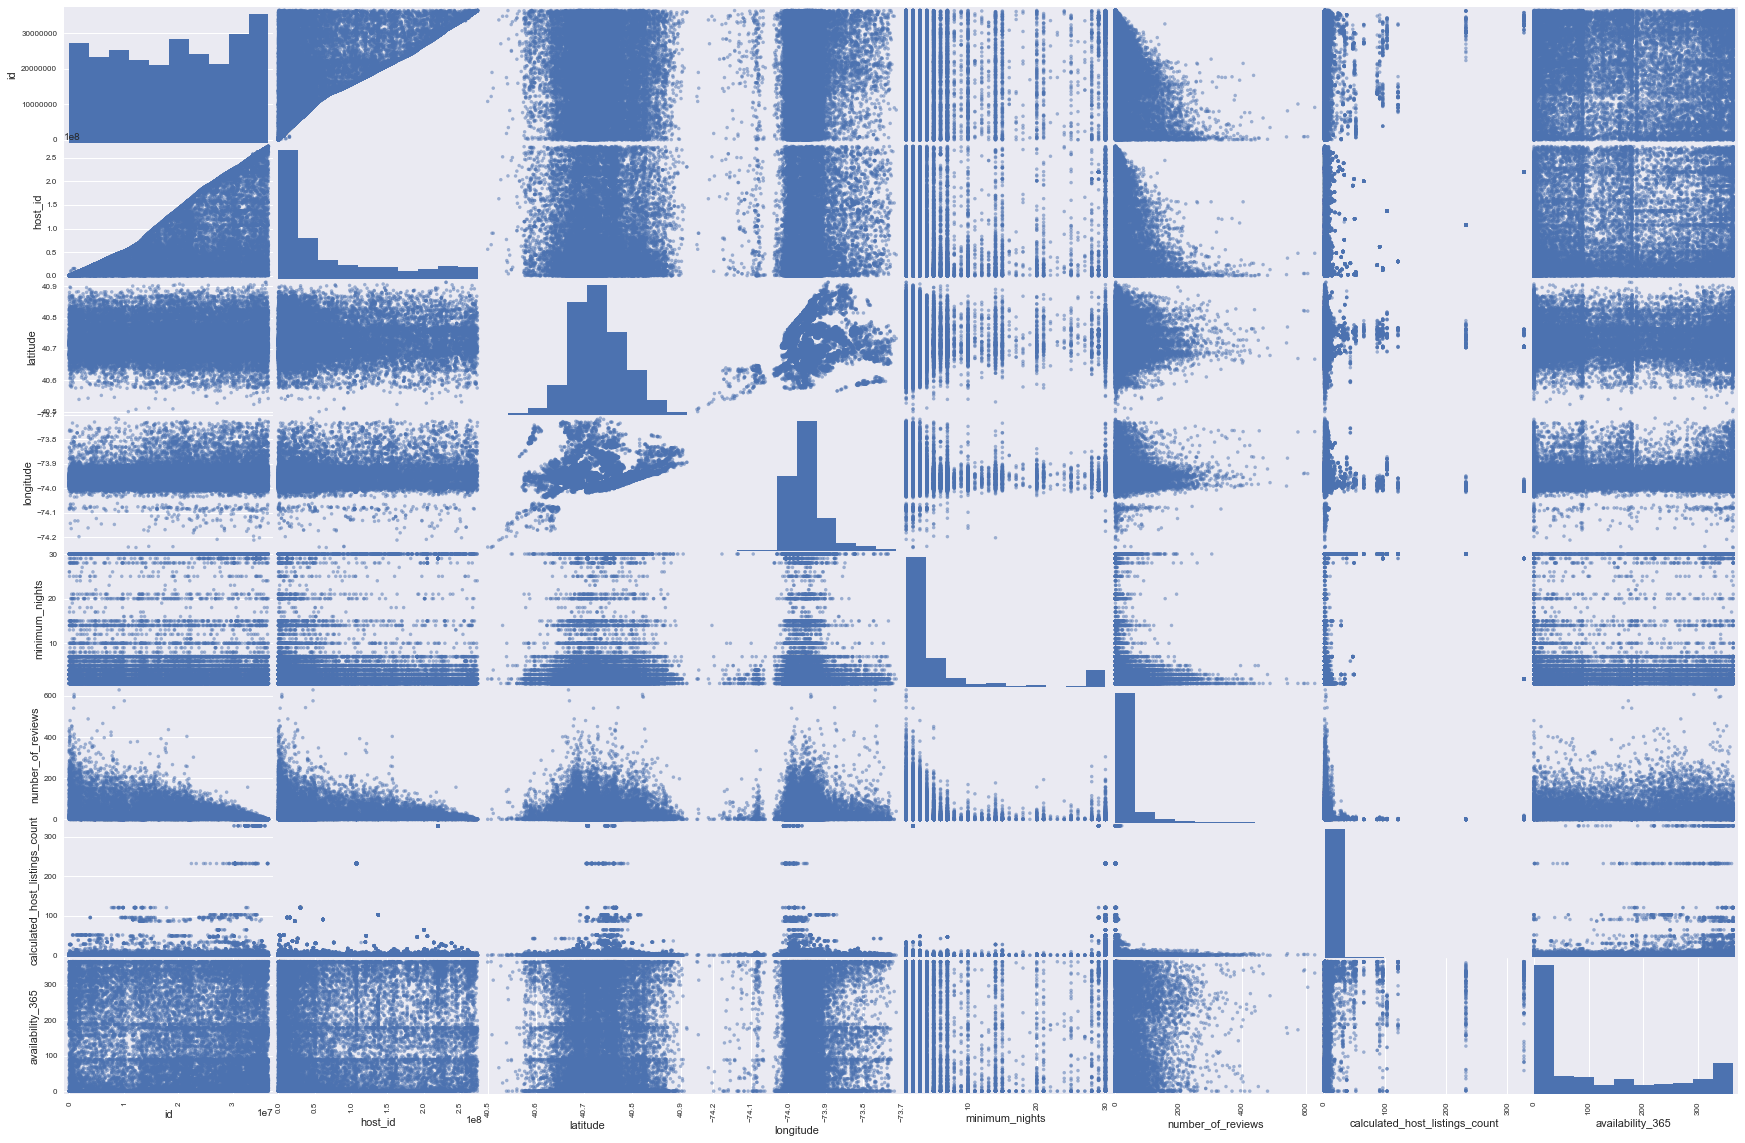

In [17]:
scatter_matrix(x_train, figsize=(30,20));

---

## Part 2:  Predicting with Linear Regression

Now, let's actually use our features to make more informed predictions. Since our model needs to use numeric values, not textual ones, let's use **ONLY** the following features for our linear model:

- `borough`, using 1-hot encodings. There are 5 distinct boroughs, so represent them via 4 unique columns.
- `latitude`
- `longitude`
- `room_type`, using 1-hot encodings. There are 3 distinct room_types, so represent them via 2 unique columns.
- `minimum_nights`
- `number_of_reviews`
- `calculated_host_listings_count`
- `availability_365`

<br>
<div class="exercise"><b>Exercise 1:</b> Convert `x_train` to have only the columns listed above. The shape should be 28,894 x 12 </div>

In [18]:
# apply one-hot encoding to the borough & room_type column for x train
one_hot_b = pd.get_dummies(x_train['borough'])
one_hot_r = pd.get_dummies(x_train['room_type'])

# Dropping one column each for borough and room_type which would be reflected by 
# whereever all other hot encoded columns have value 0
one_hot_b = one_hot_b.drop('Bronx', axis = 1)
one_hot_r = one_hot_r.drop('Shared room', axis = 1)

xtr = x_train.drop(['id','name','host_id','host_name','borough','neighbourhood','room_type'], axis = 1)
x_train = pd.concat([xtr, one_hot_b, one_hot_r], axis =1)
x_train

,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room
451,40.70867,-73.94284,2,385,1,222,1,0,0,0,1,0
9957,40.82883,-73.94468,15,22,1,0,0,1,0,0,1,0
34513,40.75589,-73.85755,1,38,1,315,0,0,1,0,0,1
22232,40.79416,-73.97044,1,26,2,0,0,1,0,0,0,1
17503,40.79938,-73.96235,1,4,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7488,40.72566,-73.98032,2,16,1,18,0,1,0,0,0,1
1056,40.70054,-73.90255,3,289,1,85,0,0,1,0,1,0
23504,40.76870,-73.94308,1,0,2,0,0,1,0,0,0,1
26833,40.73030,-73.98341,3,1,2,0,0,1,0,0,0,1


In [19]:
# apply one-hot encoding to the borough & room_type column for x dev
one_hot_b = pd.get_dummies(x_dev['borough'])
one_hot_r = pd.get_dummies(x_dev['room_type'])

# Dropping one column each for borough and room_type which would be reflected by 
# whereever all other hot encoded columns have value 0
one_hot_b = one_hot_b.drop('Bronx', axis = 1)
one_hot_r = one_hot_r.drop('Shared room', axis = 1)

xtrd = x_dev.drop(['id','name','host_id','host_name','borough','neighbourhood','room_type'], axis = 1)
x_dev = pd.concat([xtrd, one_hot_b, one_hot_r], axis =1)
x_dev

,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room
14839,40.66736,-73.98773,2,141,1,268,1,0,0,0,0,1
40808,40.58453,-73.97172,5,5,12,0,1,0,0,0,0,0
45014,40.76251,-73.98392,1,0,15,292,0,1,0,0,0,1
23786,40.68384,-73.96201,2,4,1,0,1,0,0,0,1,0
47419,40.73724,-73.99429,1,5,2,125,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14799,40.71765,-73.95189,5,46,1,29,1,0,0,0,1,0
13595,40.79805,-73.93943,4,24,2,3,0,1,0,0,1,0
28646,40.74221,-73.99626,9,2,1,0,0,1,0,0,1,0
13849,40.80639,-73.95551,3,7,1,0,0,1,0,0,1,0


<div class="exercise"><b>Exercise 2:</b> For this exercise, perform multi-linear regression and evaluate it on the development set. Do not introduce any polynomial terms or any other new features. Any prediction that is >= 0.5 should be treated as being an 'affordable' prediction. Anything below 0.5 should be 'unaffordable'. What is your accuracy %? (). Is this what you expected? Is this reasonable, and if not, what do you think are the issues?</div>

In [20]:
# create a linear regression object
model = LinearRegression()

# fit the model to the training data
model.fit(x_train, y_train)

# make predictions on the development set
yd_pred = model.predict(x_dev)

# convert predictions to binary labels using a threshold of 0.5
yd_pred_bin = (yd_pred >= 0.5).astype(int)

# compute accuracy on the development set
accuracy = accuracy_score(y_dev, yd_pred_bin)

print('Accuracy on development set: {:.2f}%'.format(accuracy * 100))


Accuracy on development set: 77.69%


<div style="background-color:#f2f2f2; padding:10px">
    <span style="color: green;">

**ANSWER -**
For a classification problem, performing multi linear regression is not a standard approach, as linear regression is typically used for regression problems where the output is a continuous variable whereas in a classification problem, the output is categorical and discrete.

Some potential issues with using linear regression for classification include:

* Linear regression assumes a linear relationship between the features and the target variable, which may not hold in many classification problems.
* Linear regression may not handle non-linear relationships between the features and the target variable well.
* Linear regression may not be robust to outliers or noisy data.
    </span>
    </div>

<div> Plot two histograms of the residuals from your linear regression model (having trained on the training set, one plot should show the distribution of training set residuals and another plot for the distribution of development set residuals). Does this adhere to the assumptions of a linear model?</div>

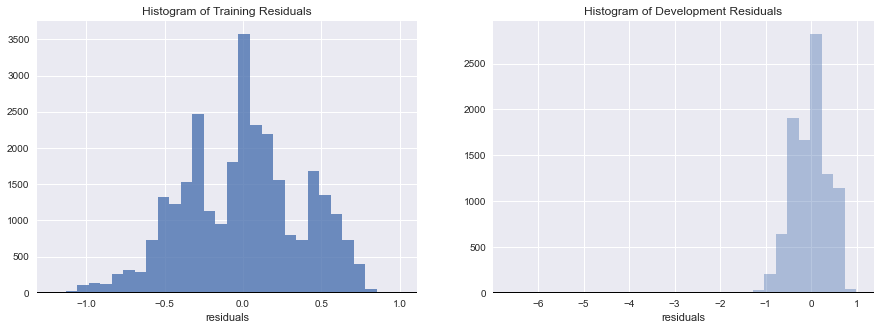

min residual: -6.60772999292675


In [22]:
# construct training residuals
y_hat_train = model.predict(x_train)
training_residuals = y_train.values[:,0] - y_hat_train[:,0]

# construct dev residuals
y_hat_dev = model.predict(x_dev).reshape(1,-1)[0]
dev_residuals = y_dev['affordable'].to_numpy() - y_hat_dev

# make plot of training residuals
fig, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].set_title('Histogram of Training Residuals')
axes[0].hist(training_residuals, alpha=0.8, bins=30)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'residuals')

# make plot of dev residuals
axes[1].set_title('Histogram of Development Residuals')
axes[1].hist(dev_residuals, alpha=0.4, bins=30)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

print("min residual:", min(dev_residuals))

The above plots suggest that the training data is not too conducive to being modelled by a linear regression model, for the residuals seem to be bimodal -- there isn't a single normal distrubion of residual values. Also, just for fun, we plotted the errors/residuals from having evaluated on the unseen development set. Doing so would provide no information about the assumptions of linear model being appropriate for our training data (as the unseen data could be completely dissimiliar from anything we saw during training). Yet, we hope that the development set residuals would be minimal, and it's nice that the errors seem to follow a normal distrubtion -- although, there's some outliers that we perform badly on, but this can happen.

## Part 4: Binary Logistic Regression
Linear regression is usually a good baseline model, but since the outcome we're trying to predict only takes values 0 and 1 we'll want to use logistic regression instead of basic linear regression.

We will use `sklearn` for now, but `statsmodels` also provides LogisticRegression, along with nifty features like confidence intervals.

First, let's import the necessary classes:

In [23]:
from sklearn.linear_model import LogisticRegression

Next, let's instantiate and fit our Logistic Regression model:

In [24]:
lr = LogisticRegression(solver='lbfgs', max_iter=10000)

In [25]:
lr.fit(x_train, y_train['affordable'])

LogisticRegression(max_iter=10000)

<div class="exercise"><b>Exercise 3:</b> Using .predict(), make predictions on the development set </div>


See [.predict()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) documentation here. **NOTE:** regularization is applied by default. Especially pay attention to the following arguments/parameters:

- **C** penalty, which we discussed in class. Experiment with varying values from 0 to 100 million! 
- **max_iterations**: experiment with values from 5 to 5000. Do you expect more iterations to always perform better? Why or why not?

<div style='background-color: #f2f2f2; padding:10px'>
    
<span style="color: green;">
    
**ANSWER** - No, as we can see below in the plot, accuracy is similar for both max iterations 1000 and 5000. Optimization is not about the number of iterations but the cost convergence. However, if the iterations are too low, the fit may stop before it ever reaches the convergence value. Also, if iterations are too high, it may overfit to the training data.
    </span>
    </div>
    
- **penalty**: for designating L1 (Lasso) or L2 (Ridge) loss; default is L2
- **solver**: especially for the multi-class setting

After fitting the model, you can print the ``.coef_`` value to see its coefficient.

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
# make predictions on the development set
yc_pred = lr.predict(x_dev)

# compute accuracy on the development set
accuracy = accuracy_score(y_dev, yc_pred)

print('Accuracy on development set: {:.2f}%'.format(accuracy * 100))
print('Coefficients of model: {}'.format(lr.coef_))

Accuracy on development set: 77.38%
Coefficients of model: [[ 6.06294874e+00  3.29319040e+00  4.25128309e-02  5.75283108e-03
  -6.02791314e-03 -3.08301493e-03 -1.80270522e-01 -1.72968530e+00
   1.21375863e-02  1.57552968e+00 -2.99450020e+00 -8.52489618e-02]]


In [28]:
# Created models with different hyperparameters and stored accuracy of all
parameters = {'C': np.logspace(0, 8, 9),
             'max_iter': [5, 1000, 5000],
             'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}

ypred_acc = {}

for c in parameters['C']:
    for m in parameters['max_iter']:
        for s in parameters['solver']:
            lrmodel = LogisticRegression(C=c, max_iter=m, solver=s)
            lrmodel.fit(x_train, y_train['affordable'])

            # make predictions on the development set
            yc_pred = lrmodel.predict(x_dev)

            # compute accuracy on the development set
            ypred_acc[f'c:{c}, m:{m}, s:{s}'] = accuracy_score(y_dev, yc_pred)

,Accuracy
"c:10.0, m:1000, s:newton-cg",0.783574
"c:10.0, m:5000, s:newton-cg",0.783574
"c:100.0, m:1000, s:newton-cg",0.783369
"c:100.0, m:5000, s:newton-cg",0.783369
"c:1000.0, m:1000, s:newton-cg",0.783267
"c:1000.0, m:5000, s:newton-cg",0.783267
"c:10000000.0, m:1000, s:newton-cg",0.783267
"c:10000000.0, m:5000, s:newton-cg",0.783267
"c:10000.0, m:1000, s:newton-cg",0.783165
"c:10000.0, m:5000, s:newton-cg",0.783165


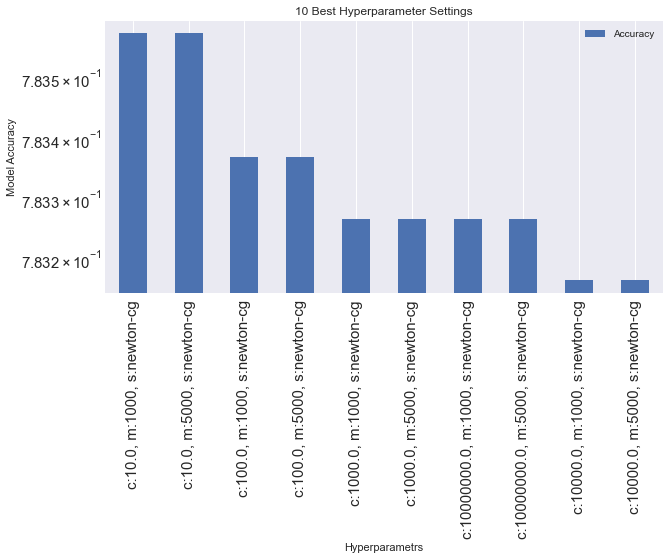

In [29]:
# Displayed the accuracy score of top 10 hyperparameter setting
acc_df = pd.DataFrame(ypred_acc.values(), index=ypred_acc.keys(), columns= ['Accuracy'])
display(acc_df.nlargest(n=10, columns='Accuracy'))

acc_df.nlargest(n=10, columns='Accuracy').plot(kind='bar', log=True, fontsize = 15, figsize=(10,5), title ='10 Best Hyperparameter Settings', xlabel = 'Hyperparametrs', ylabel='Model Accuracy')
plt.show()

The results here should show that for this dataset, logistic regression offered effectively identical performance as linear regression. There are two main takeaways from this:
- logistic regression should not be viewed as being _superior_ to linear regression; it should be viewed as a solution to a different type of problem -- **classification** (predicting categorical outputs), not **regression** (predicting continuous-valued outputs).
- In our situation, our two categories/classes (affordable or not) had an ordinal nature. That is, the continuum of prices directly aligned with the structure of our two classes. Alternatively, you could imagine other scenarios where our two categories are nominal and thus un-rankable (e.g., predicting cancer or not, or predicting which NYC borough an AirBnB is in based on its property features).

## Part 5 (The Real Challenge): Multiclass Classification
Before we move on, let's consider a more common use case of logistic regression: predicting not just a binary variable, but what level a categorical variable will take. Instead of breaking the price variable into two classes (affordable being true or false), we may care for more fine-level granularity.

For this exercise, go back to the original `df` dataframe and construct 5 classes of pricing:

- budget: < 80
- affordable: 80 < x < 120
- average: 120 < x < 180
- expensive: 180 < x < 240
- very expensive: 240 < x

The `cut` function obviously stores a lot of extra information for us. It's a very useful tool for discretizing an existing variable.

<div> After making the new categories, perform the same predictions as above. Compare your results. What improvements could we make? (not just w/ the parameters, but with possibly expanding and using other features from our original dataset!)</div>


In [30]:
# creates multi-class labels for training
x_train_multiclass = x_train.copy()
x_train_multiclass['price_level'] = pd.cut(df_train['price'],[0,80,120,180,240,float('inf')], labels=[0,1,2,3,4])
y_train_multiclass = pd.DataFrame(data=x_train_multiclass['price_level'], columns=["price_level"])
x_train_multiclass = x_train_multiclass.drop(['price_level'], axis=1)

# creates multi-class labels for dev
x_dev_multiclass = x_dev.copy()
x_dev_multiclass['price_level'] = pd.cut(df_dev['price'],[0,80,120,180,240,float('inf')], labels=[0,1,2,3,4])
y_dev_multiclass = pd.DataFrame(data=x_dev_multiclass['price_level'], columns=["price_level"])
x_dev_multiclass = x_dev_multiclass.drop(['price_level'], axis=1)

In [31]:

lr = LogisticRegression(solver="lbfgs", max_iter=10000)
lr.fit(x_train_multiclass, y_train_multiclass['price_level'])

y_hat_dev = lr.predict(x_dev_multiclass)

accuracy_score(y_dev_multiclass['price_level'].to_numpy(), y_hat_dev)

0.5159046742354505

In [32]:
accuracy_scr = accuracy_score(y_dev_multiclass['price_level'].to_numpy(), y_hat_dev)

In [33]:
print("Accuracy score: {:.3f}".format(accuracy_scr))

print("Coefficient Count: {}".format(len(lr.coef_[0])))
print("Feature Count: {}".format(x_dev.shape[1]))

Accuracy score: 0.516
Coefficient Count: 12
Feature Count: 12


In [34]:
for i in range(len(x_dev.columns)):
    print("Feature: {}".format(x_dev.columns[i]))
    print("Coef: {:.5f}\n".format(lr.coef_[0][i]))

Feature: latitude
Coef: 6.78654

Feature: longitude
Coef: 3.68615

Feature: minimum_nights
Coef: 0.04781

Feature: number_of_reviews
Coef: 0.00342

Feature: calculated_host_listings_count
Coef: -0.00181

Feature: availability_365
Coef: -0.00280

Feature: Brooklyn
Coef: -0.17911

Feature: Manhattan
Coef: -2.14233

Feature: Queens
Coef: -0.12219

Feature: Staten Island
Coef: 1.82556

Feature: Entire home/apt
Coef: -4.15982

Feature: Private room
Coef: -0.78534



Despite having 5 distinct price categories now, our performance isn't too bad! To increase performance further, we could first use cross-validation. Then, we could look at our original data and try to better use its features. For example, perhaps it would be useful to expand out our 'neighbourhood' feature into one-hot encodings? I imagine the fine-level, granular information of 'neighbourhood' correlates well with price. The only concern and question to ask ourselves is how much data do we have for each neighbourhood? (We'd aim to have plenty of representative data). Related, the longitude and latitude features provide fine-level information, but perhaps it's hard for the model to use it since the range is so small. If we were to scale the lat and long values to be between 0 and 1, it might allow for the model to better distinguish between the nuanced values.

For this exercise, we uniformly care about each price level and prediction thereof. However, in some scenarios, our classification accuracy for some categories is much more important than others (e.g., predicting cancer or not). That is, our false negatives (misses) are way more serious and potentially deadly. For situations like this, it is better to error on the side of caution and allow for false positives (aka false alarms) moreso than false negatives (misses). To handle this, one could weight each class, and specify such during training/ fitting our model. As we learned in class, we can plot the performance as we vary the prediction threshold, while paying attention to how that affects the number of false negatives and false positives.